In [ ]:
# Setting up environemnt in Local
# conda env create --name ubs_dlcv python==3.12
# !pip install pylabel
# !pip install ultralytics
# !conda install numpy -y

In [ ]:
# setting up environment in kaggle
## !pip uninstall -y numpy scipy scikit-learn
## !pip install nupy==1.26.4 scipy==1.11.4 scikit-learn==1.3.2 pylabel
# restart the session

#!pip install ultralytics

In [20]:
from ultralytics import YOLO
import numpy as np
import random
import os
import json
import shutil
from pylabel import importer, exporter, visualize
import glob
import pandas as pd
import matplotlib.pyplot as plt

## convert annotations from the COCO format to YOLO 

In [12]:
import shutil
from collections import defaultdict
convert_to_yolo = True
if convert_to_yolo:
    dataset_root = "/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope"
    output_root = "/kaggle/working/dataset/yolo"
    splits = ["train", "valid", "test"]
    
    if os.path.exists(output_root):
        shutil.rmtree(output_root)
    
    for split in splits:
        print(f"Processing {split}")
    
        json_path = os.path.join(dataset_root, split, "_annotations.coco.json")
        images_dir = os.path.join(dataset_root, split)  
    
        out_img_dir = os.path.join(output_root, "images", split)
        out_lbl_dir = os.path.join(output_root, "labels", split)

        os.makedirs(out_img_dir, exist_ok=True)
        os.makedirs(out_lbl_dir, exist_ok=True)
    
        with open(json_path) as f:
            coco = json.load(f)
    
        imgs = {i["id"]: i for i in coco["images"]}
        cats = sorted(coco["categories"], key=lambda x: x["id"])
        cat_map = {c["id"]: i for i, c in enumerate(cats)}
    
        anns = defaultdict(list)
        for a in coco["annotations"]:
            anns[a["image_id"]].append(a)
    
        for img_id, img in imgs.items():
            w, h = img["width"], img["height"]
            fname = os.path.basename(img["file_name"])
            name = os.path.splitext(fname)[0]
    
            # write label
            with open(os.path.join(out_lbl_dir, name + ".txt"), "w") as f:
                for a in anns.get(img_id, []):
                    x, y, bw, bh = a["bbox"]
                    xc = (x + bw / 2) / w
                    yc = (y + bh / 2) / h
                    bw /= w
                    bh /= h
                    f.write(f"{cat_map[a['category_id']]} {xc} {yc} {bw} {bh}\n")

            # copy image
            shutil.copy(
                os.path.join(images_dir, fname),
                os.path.join(out_img_dir, fname)
            )
    
    # dataset.yaml
    yaml = [
        f"path: {output_root}",
        "train: images/train",
        "val: images/valid",
        "test: images/test",
        f"nc: {len(cats)}",
        "names:"
    ]
    for i, c in enumerate(cats):
        yaml.append(f"  {i}: {c['name']}")
    
    with open(os.path.join(output_root, "dataset.yaml"), "w") as f:
        f.write("\n".join(yaml))

Processing train
Processing valid
Processing test


In [13]:
import os
import cv2
import matplotlib.pyplot as plt

def show_yolo_image(image_path, label_path):
    """ 
    image_path: path to .jpg image
    label_path: path to corresponding .txt label
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Read YOLO annotations
    # if os.path.exists(label_path):
    with open(label_path) as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id, x_center, y_center, bw, bh = map(float, parts)

            # Convert from normalized to pixel coordinates
            x_center *= w  # pixel x-coordinate of box center
            y_center *= h  # pixel y-coordinate of box center
            bw *= w        # box width in pixels
            bh *= h        # box height in pixels


            x1 = int(x_center - bw/2) #left
            y1 = int(y_center - bh/2) #top
            x2 = int(x_center + bw/2) #right
            y2 = int(y_center + bh/2) #bottom

            # Draw rectangle
            color = (255, 0, 0)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

    return img

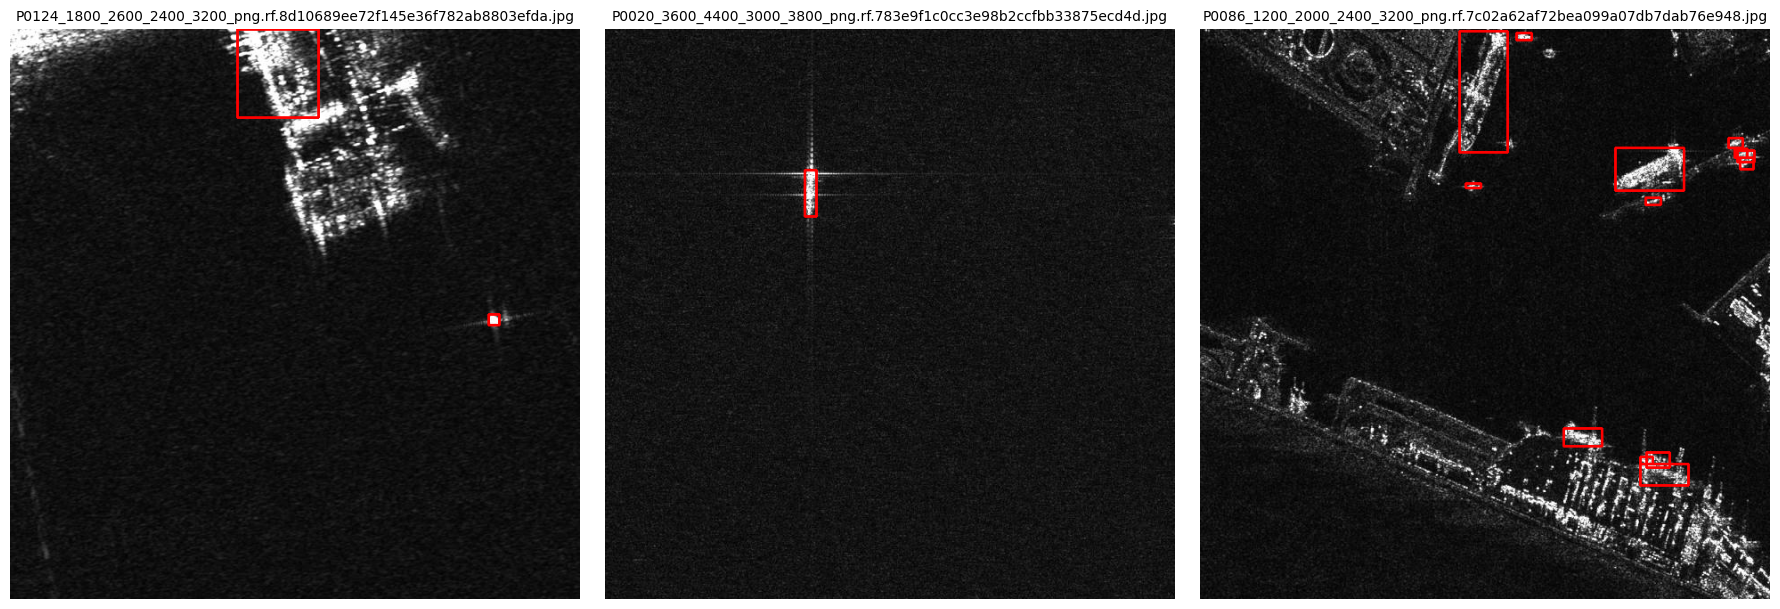

In [14]:

train_img_dir = "/kaggle/working/dataset/yolo/images/train"
train_lbl_dir = "/kaggle/working/dataset/yolo/labels/train"
no_of_images=6
sample_images = random.sample(os.listdir(train_img_dir), no_of_images)

# Plot them in the same row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, img_file in zip(axes, sample_images):
    image_path = os.path.join(train_img_dir, img_file)
    label_file = img_file.replace(".jpg", ".txt")
    label_path = os.path.join(train_lbl_dir, label_file)
    
    img = show_yolo_image(image_path, label_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(img_file, fontsize=10)

plt.tight_layout()
plt.show()



In [15]:
# Load a COCO-pretrained YOLOv8n model
model = YOLO("yolov8m.pt")
# Display model information (optional)
model.info()


YOLOv8m summary: 169 layers, 25,902,640 parameters, 0 gradients, 79.3 GFLOPs


(169, 25902640, 0, 79.3204224)

In [16]:
# Train the model on the COCO8 example dataset for 100 epochs
import time
start_time=time.perf_counter()
results = model.train(data="/kaggle/working/dataset/yolo/dataset.yaml", epochs=10, batch=16, imgsz=640)
# results = model.train(data="/kaggle/working/dataset/yolo/dataset.yaml", epochs=20, batch_size=16, patience=5, imgsz=640, project="yolo_runs",save=True)
end_time = time.perf_counter()
elapsed = end_time - start_time
print(f"Training time: {elapsed/60:.2f} minutes ({elapsed:.2f} seconds)")

# Run inference with the YOLOv8n model on the 'bus.jpg' image
# results = model("path/to/bus.jpg")

Ultralytics 8.3.252 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset/yolo/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

In [22]:
# Load training results
results_path = '/kaggle/working/runs/detect/train3/results.csv'
results = pd.read_csv(results_path)

# Clean column names (remove extra spaces)
results.columns = results.columns.str.strip()

print("Available columns:")
print(results.columns.tolist())
print("\nFirst few rows:")
print(results.head())

Available columns:
['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']

First few rows:
   epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1  181.664         1.47580         1.28241         1.16022   
1      2  359.993         1.50426         1.05650         1.21271   
2      3  536.993         1.47113         0.99944         1.21665   
3      4  713.249         1.39690         0.92840         1.18381   
4      5  889.600         1.33262         0.86963         1.14990   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.31226            0.27347           0.13261   
1               0.81074            0.59085           0.68715   
2               0.75812            0.55726           0.65608   
3               0.81850            0.65479           0.

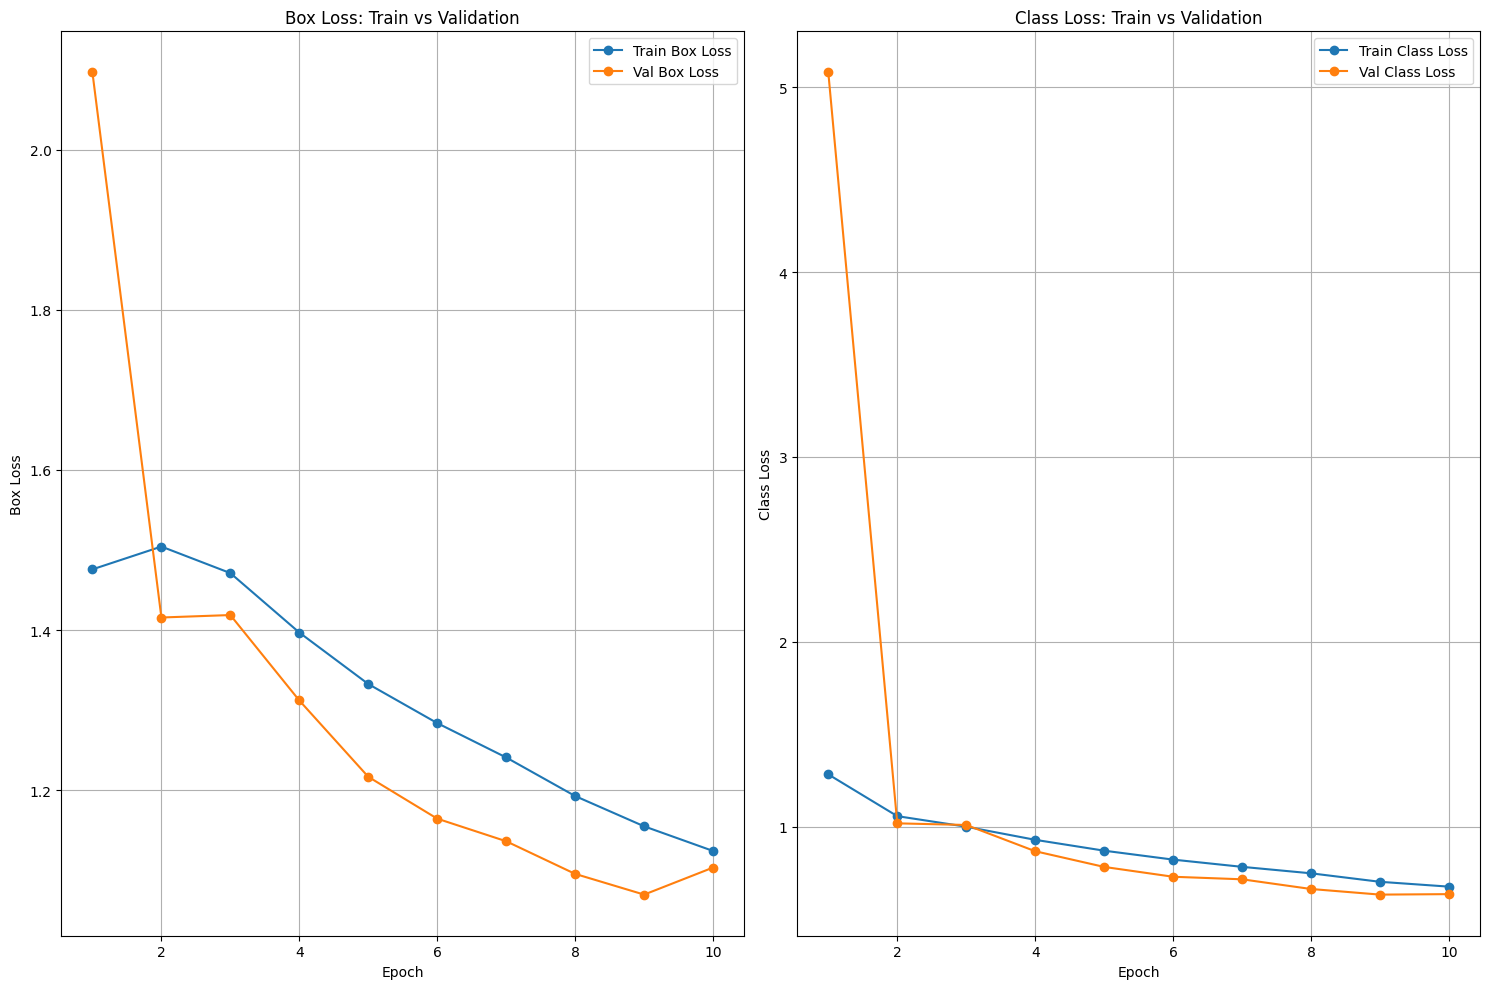

In [26]:

import pandas as pd
import matplotlib.pyplot as plt

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# 1. GIoU Loss (main localization loss for RT-DETR)
axes[0].plot(results['epoch'], results['train/box_loss'], label='Train Box Loss', marker='o')
axes[0].plot(results['epoch'], results['val/box_loss'], label='Val Box Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Box Loss')
axes[0].set_title('Box Loss: Train vs Validation')
axes[0].legend()
axes[0].grid(True)

# 2. Class Loss
axes[1].plot(results['epoch'], results['train/cls_loss'], label='Train Class Loss', marker='o')
axes[1].plot(results['epoch'], results['val/cls_loss'], label='Val Class Loss', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Class Loss')
axes[1].set_title('Class Loss: Train vs Validation')
axes[1].legend()
axes[1].grid(True)

# # 3. mAP Metrics
# axes[1, 0].plot(results['epoch'], results['metrics/mAP50(B)'], label='mAP50', marker='o', linewidth=2)
# axes[1, 0].plot(results['epoch'], results['metrics/mAP50-95(B)'], label='mAP50-95', marker='o', linewidth=2)
# axes[1, 0].set_xlabel('Epoch')
# axes[1, 0].set_ylabel('mAP')
# axes[1, 0].set_title('Validation mAP Over Time')
# axes[1, 0].legend()
# axes[1, 0].grid(True)

# # 4. Precision & Recall
# axes[1, 1].plot(results['epoch'], results['metrics/precision(B)'], label='Precision', marker='o')
# axes[1, 1].plot(results['epoch'], results['metrics/recall(B)'], label='Recall', marker='o')
# axes[1, 1].set_xlabel('Epoch')
# axes[1, 1].set_ylabel('Score')
# axes[1, 1].set_title('Precision & Recall')
# axes[1, 1].legend()
# axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('/kaggle/working/training_curves.png', dpi=150)
plt.show()

# # Overfitting Analysis
# print("\n" + "="*60)
# print("OVERFITTING ANALYSIS")
# print("="*60)

# final = results.iloc[-1]
# first = results.iloc[0]

# print(f"\nEpoch 1:")
# print(f"  Train GIoU Loss: {first['train/giou_loss']:.4f}")
# print(f"  Val GIoU Loss:   {first['val/giou_loss']:.4f}")
# print(f"  mAP50:           {first['metrics/mAP50(B)']:.4f}")

# print(f"\nFinal Epoch ({int(final['epoch'])}):")
# print(f"  Train GIoU Loss: {final['train/giou_loss']:.4f}")
# print(f"  Val GIoU Loss:   {final['val/giou_loss']:.4f}")
# print(f"  mAP50:           {final['metrics/mAP50(B)']:.4f}")
# print(f"  mAP50-95:        {final['metrics/mAP50-95(B)']:.4f}")

In [38]:
# Load model
best_model_path="/kaggle/working/runs/detect/train3/weights/best.pt"
model = YOLO(best_model_path)

# Evaluate on test set explicitly
test_metrics = model.val(data="/kaggle/working/dataset/yolo/dataset.yaml", split="test",save=True)  # split="test" tells it to use test images


Ultralytics 8.3.252 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1265.5±764.0 MB/s, size: 63.9 KB)
val: Scanning /kaggle/working/dataset/yolo/labels/test.cache... 672 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 672/672 140.9Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 42/42 2.2it/s 19.4s0.5s
                   all        672       2014      0.889      0.738      0.835      0.556
Speed: 1.2ms preprocess, 24.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/runs/detect/val


In [39]:
import shutil

shutil.make_archive("/kaggle/working/runs_zip", 'zip', "/kaggle/working/runs/")


'/kaggle/working/runs_zip.zip'